## IMPORTING LIBRARIES

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns

## GRADIENT BOOSTING MODEL

In [13]:
# Load the dataset
df = pd.read_csv('Integrated_Dataset.csv')

import numpy as np


# Convert 'Datetime' to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Extract features from 'Datetime'
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month

# Optionally: Create binary columns for special events if needed
df['Special Event'] = df['Event Name'].notnull().astype(int)

# Drop columns that are not needed for the model
features = ['Junction', 'Hour', 'DayOfWeek', 'Month', 'Temperature', 'Humidity', 'Precipitation', 'Windspeed', 'Special Event']
target = 'Vehicles'

X = df[features]
y = df[target]


In [14]:
# Preprocessing for numerical and categorical data
categorical_features = ['Junction']
numerical_features = ['Hour', 'DayOfWeek', 'Month', 'Temperature', 'Humidity', 'Precipitation', 'Windspeed', 'Special Event']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline that includes preprocessing and the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 98.15961866312702


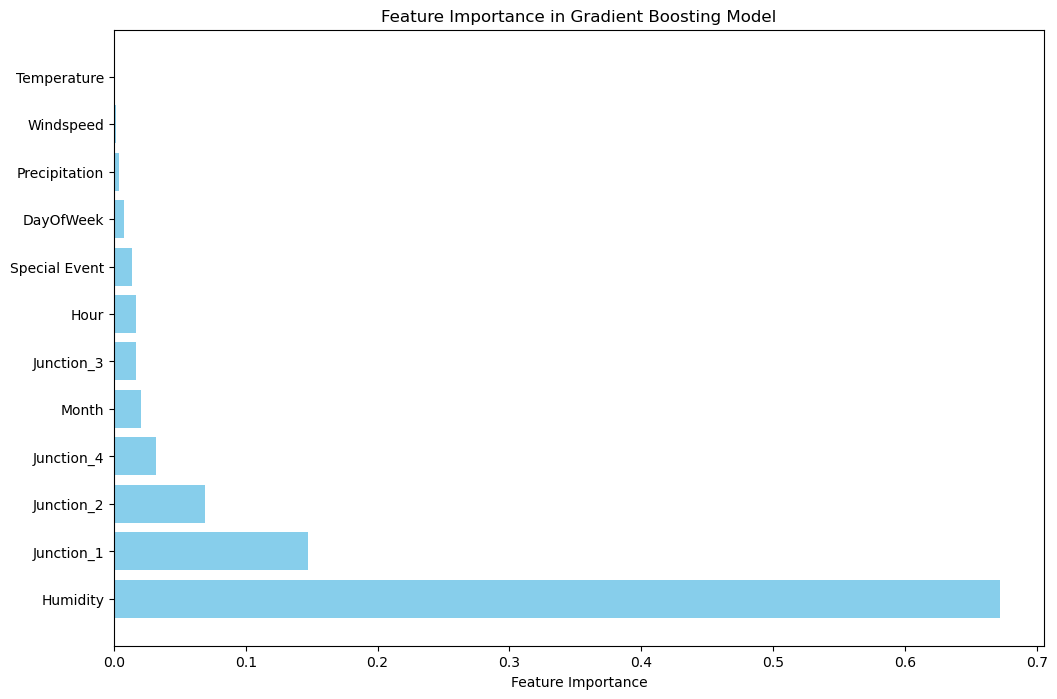

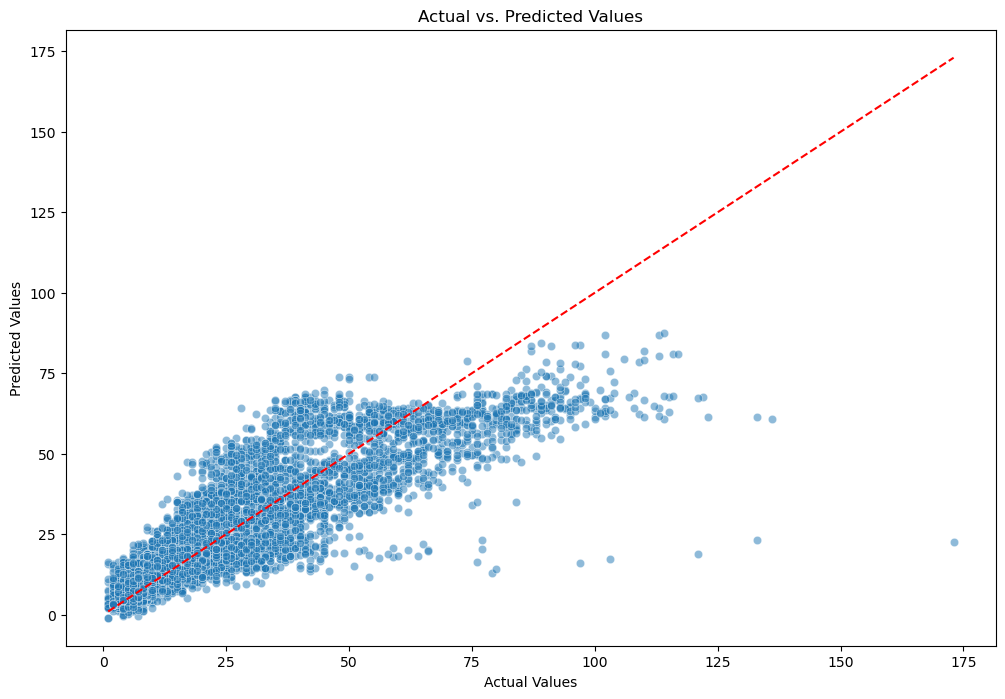

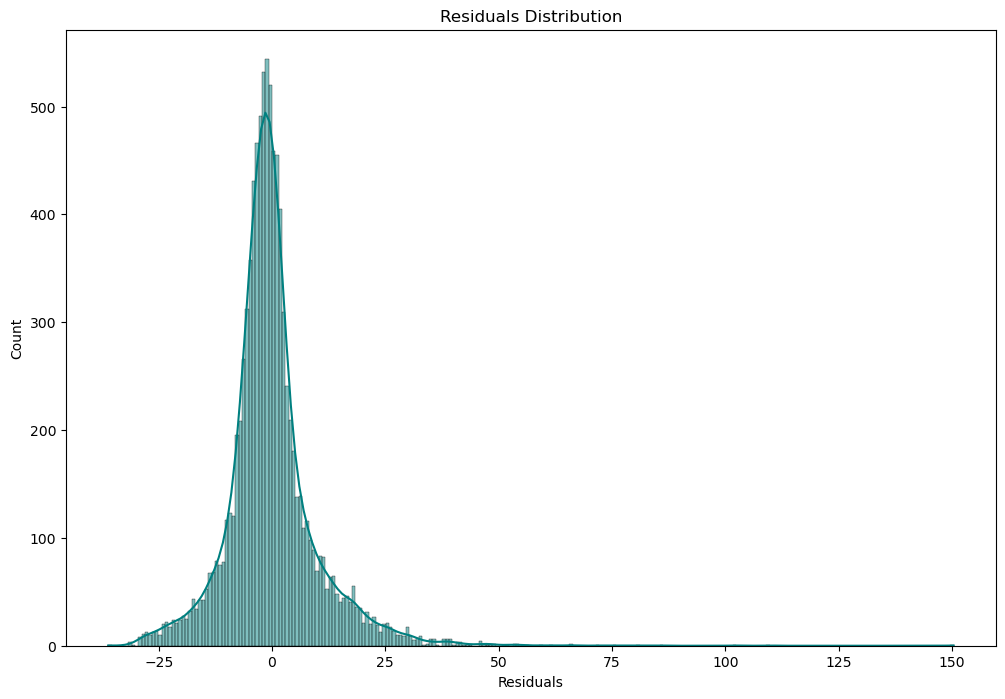

In [16]:
# Feature Importance Plot
importances = model.named_steps['regressor'].feature_importances_
feature_names = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
feature_names = list(feature_names) + numerical_features

sorted_indices = np.argsort(importances)
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting Model')
plt.gca().invert_yaxis()
plt.show()

# Prediction vs. Actual Values Plot
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
plt.figure(figsize=(12, 8))
sns.scatterplot(data=results_df, x='Actual', y='Predicted', alpha=0.5)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], 
         [results_df['Actual'].min(), results_df['Actual'].max()], 
         color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True, color='teal')
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()


## LSTM MODEL

In [17]:


# Load the full dataset
df_full = pd.read_csv('Integrated_Dataset.csv')

# Convert Datetime column to datetime format
df_full['Datetime'] = pd.to_datetime(df_full['Datetime'])

# Filter data for the chosen junction
junction = 1
df_junction_full = df_full[df_full['Junction'] == junction]
#df_junction_full

In [18]:
# Aggregate to hourly data
df_junction_full.set_index('Datetime', inplace=True)

df_junction_aggregated = df_junction_full.resample('H').agg({
    'Vehicles': 'sum',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Precipitation': 'sum',
    'Windspeed': 'mean',
    'Event Name': 'first'
}).reset_index()

# Feature engineering
df_junction_aggregated['Hour'] = df_junction_aggregated['Datetime'].dt.hour
df_junction_aggregated['DayOfWeek'] = df_junction_aggregated['Datetime'].dt.dayofweek
df_junction_aggregated['Special Event'] = df_junction_aggregated['Event Name'].notna().astype(int)
df_junction_aggregated

,Datetime,Vehicles,Temperature,Humidity,Precipitation,Windspeed,Event Name,Hour,DayOfWeek,Special Event
0,2015-11-01 00:00:00,15,17.0,75.6,0.000,8.3,Diwali Festival,0,6,1
1,2015-11-01 01:00:00,13,17.0,75.6,0.000,8.3,Diwali Festival,1,6,1
2,2015-11-01 02:00:00,10,17.0,75.6,0.000,8.3,Diwali Festival,2,6,1
3,2015-11-01 03:00:00,7,17.0,75.6,0.000,8.3,Diwali Festival,3,6,1
4,2015-11-01 04:00:00,9,17.0,75.6,0.000,8.3,Diwali Festival,4,6,1
...,...,...,...,...,...,...,...,...,...,...
14587,2017-06-30 19:00:00,105,25.6,89.9,0.043,16.6,No Event,19,4,1
14588,2017-06-30 20:00:00,96,25.6,89.9,0.043,16.6,No Event,20,4,1
14589,2017-06-30 21:00:00,90,25.6,89.9,0.043,16.6,No Event,21,4,1
14590,2017-06-30 22:00:00,84,25.6,89.9,0.043,16.6,No Event,22,4,1


In [19]:


# Define features and target
features = ['Hour', 'DayOfWeek', 'Temperature', 'Humidity', 'Precipitation', 'Windspeed', 'Special Event']
target = 'Vehicles'

X = df_junction_aggregated[features]
y = df_junction_aggregated[target]

# Scale features and target
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))


In [20]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
X, y = create_dataset(X_scaled, y_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:


# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test)


Epoch 1/50
235/328 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0282

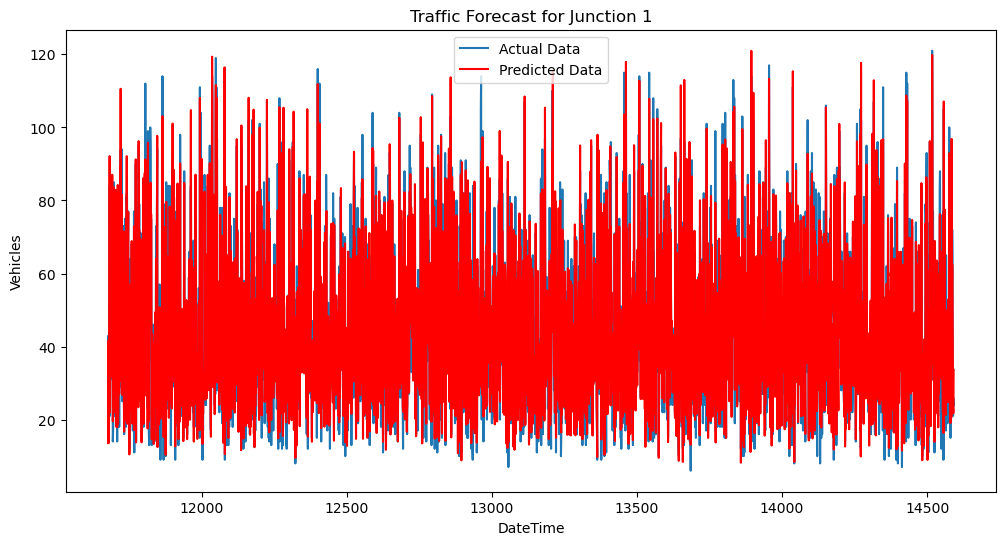

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(df_junction_aggregated.index[-len(y_test_rescaled):], y_test_rescaled, label='Actual Data')
plt.plot(df_junction_aggregated.index[-len(y_pred):], y_pred, label='Predicted Data', color='red')
plt.title(f'Traffic Forecast for Junction {junction}')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend()
print("LSTM MODEL")
plt.show()
